In [114]:
# =======================
# 라이브러리 임포트 및 환경 설정

import warnings

# 데이터 처리
import pandas as pd
import numpy as np

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc

# 전처리
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer

# 모델링
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb

# 딥러닝 (Keras)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# =======================
# 경고 무시 설정 (FutureWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

# 한글 폰트 설정 (Mac: AppleGothic, Windows: 'Malgun Gothic' 사용)
rc('font', family='AppleGothic')

# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

In [115]:
train = pd.read_csv('../../data/raw/train.csv')
test = pd.read_csv('../../data/raw/test.csv')

# 전처리 함수

In [116]:
def preprocess(df):
    """
    주어진 데이터프레임에 대해 전처리 수행:
    - 결측치 처리
    - 인코딩
    - 매핑
    - 형변환 등
    """
    # 1. 설립연도: 그대로 사용 (패스)

    # 2. 국가: 원핫 인코딩
    df = pd.get_dummies(df, columns=['국가'])

    # 3. 분야: 결측치 → 'Unknown', 원핫 인코딩
    df['분야'].fillna('Unknown', inplace=True)
    df = pd.get_dummies(df, columns=['분야'])

    # 4. 투자단계: 수동 매핑
    investment_stage_order = {
        'Seed': 0,
        'Series A': 1,
        'Series B': 2,
        'Series C': 3,
        'IPO': 4
    }
    df['투자단계'] = df['투자단계'].map(investment_stage_order)

    # 5. 직원 수: 평균으로 대체
    mean_emp = df['직원 수'].mean()
    df['직원 수'].fillna(mean_emp, inplace=True)

    # 6. 인수여부, 상장여부: 원핫 인코딩
    df = pd.get_dummies(df, columns=['인수여부', '상장여부'])

    # 7. 고객수: 중앙값으로 대체
    median_cust = df['고객수(백만명)'].median()
    df['고객수(백만명)'].fillna(median_cust, inplace=True)

    # 8. 총 투자금, 연매출: 정수형 변환
    df['총 투자금(억원)'] = df['총 투자금(억원)'].astype(int)
    df['연매출(억원)'] = df['연매출(억원)'].astype(int)

    # 9. SNS 팔로워 수: 값이 0인 경우 최빈값으로 대체
    mode_sns = df[df['SNS 팔로워 수(백만명)'] != 0]['SNS 팔로워 수(백만명)'].mode()[0]
    df.loc[df['SNS 팔로워 수(백만명)'] == 0, 'SNS 팔로워 수(백만명)'] = mode_sns

    # 10. 기업가치: 결측치 보완 + 수치 매핑
    df['기업가치(백억원)'].fillna('4500~6000', inplace=True)
    value_map = {
        '1500~2500': 2000,
        '2500~3500': 3000,
        '3500~4500': 4000,
        '4500~6000': 5250,
        '6000이상': 6500
    }
    df['기업가치(백억원)'] = df['기업가치(백억원)'].map(value_map)
    df['기업가치(백억원)'].fillna(5250, inplace=True)  # 매핑 실패 보완

    return df

# 파생변수 생성

In [117]:
def add_features(df):
    # 1. 기업나이
    df['기업나이'] = 2025 - df['설립연도']

    # 2. 직원당 매출
    df['직원당매출'] = df['연매출(억원)'] / df['직원 수'].replace(0, np.nan)

    # 3. 고객당 매출
    df['고객당매출'] = df['연매출(억원)'] / df['고객수(백만명)'].replace(0, np.nan)

    # 4. 투자수익비
    df['투자수익비'] = df['연매출(억원)'] / df['총 투자금(억원)'].replace(0, np.nan)

    # 5. SNS 팔로워 등급
    df['SNS팔로워등급'] = pd.cut(df['SNS 팔로워 수(백만명)'],
                             bins=[-1, 1, 3, 10],
                             labels=['낮음', '중간', '높음'])

    # 6. 가치대비매출 (기업가치 결측치 처리 포함)
    df['가치대비매출'] = df['기업가치(백억원)'] / df['연매출(억원)'].replace(0, np.nan)

    # 7. 총투자금당직원수
    df['총투자금당직원수'] = df['직원 수'] / df['총 투자금(억원)'].replace(0, np.nan)

    return df

# 스케일링 (MinMaxSclaer, Log)

In [118]:
def scaleing(df):
    scale_cols = [
        '설립연도',
        '투자단계',
        '직원 수',
        '고객수(백만명)',
        '총 투자금(억원)',
        '연매출(억원)',
        'SNS 팔로워 수(백만명)',
        '기업가치(백억원)',
        '기업나이',
        '직원당매출',
        '고객당매출',
        '투자수익비',
        '가치대비매출',
        '총투자금당직원수',
        'SNS팔로워등급',
        #'성공확률'
    ]
    # 스케일링 적용
    scaler = MinMaxScaler()
    train[scale_cols] = scaler.fit_transform(train[scale_cols])
    
    # 타겟변수 로그 스케일링
    #train['성공확률'] = np.log(train['성공확률'])
    return df

def scaleing_for_test(df):
    '''
    검증 데이터에는 성공확률 컬럼이 없기 때문에 로그 변환 코드를 삭제함
    '''
    scale_cols = [
        '설립연도',
        '투자단계',
        '직원 수',
        '고객수(백만명)',
        '총 투자금(억원)',
        '연매출(억원)',
        'SNS 팔로워 수(백만명)',
        '기업가치(백억원)',
        '기업나이',
        '직원당매출',
        '고객당매출',
        '투자수익비',
        '가치대비매출',
        '총투자금당직원수',
        'SNS팔로워등급'
    ]
    # 스케일링 적용
    scaler = MinMaxScaler()
    df[scale_cols] = scaler.fit_transform(df[scale_cols])

    return df

# 최종 데이터 전처리 및 저장

In [119]:
train = preprocess(train)
train = add_features(train)


test = preprocess(test)
test = add_features(test)

In [120]:
# 1. 파생변수 리스트
derived_cols = [
    '기업나이',
    '직원당매출',
    '고객당매출',
    '투자수익비',
    'SNS팔로워등급',
    '가치대비매출',
    '총투자금당직원수'
]


In [121]:
train[derived_cols].describe()

,기업나이,직원당매출,고객당매출,투자수익비,가치대비매출,총투자금당직원수
count,4376.000000,4376.000000,4376.000000,4376.000000,4376.000000,4376.000000
mean,12.993144,8.196005,259.339256,6.576375,2.854454,2.344582
std,6.554872,39.929063,681.294346,34.494157,16.781722,12.537766
min,2.000000,0.002524,0.213115,0.002337,0.354203,0.001828
25%,7.000000,1.285796,65.346939,0.987430,0.555262,0.387628
50%,13.000000,2.583085,130.461310,1.971545,0.840533,0.753905
75%,19.000000,5.134961,222.081633,3.714307,1.764706,1.467620
max,24.000000,1649.285714,11112.000000,1015.000000,437.500000,382.538462


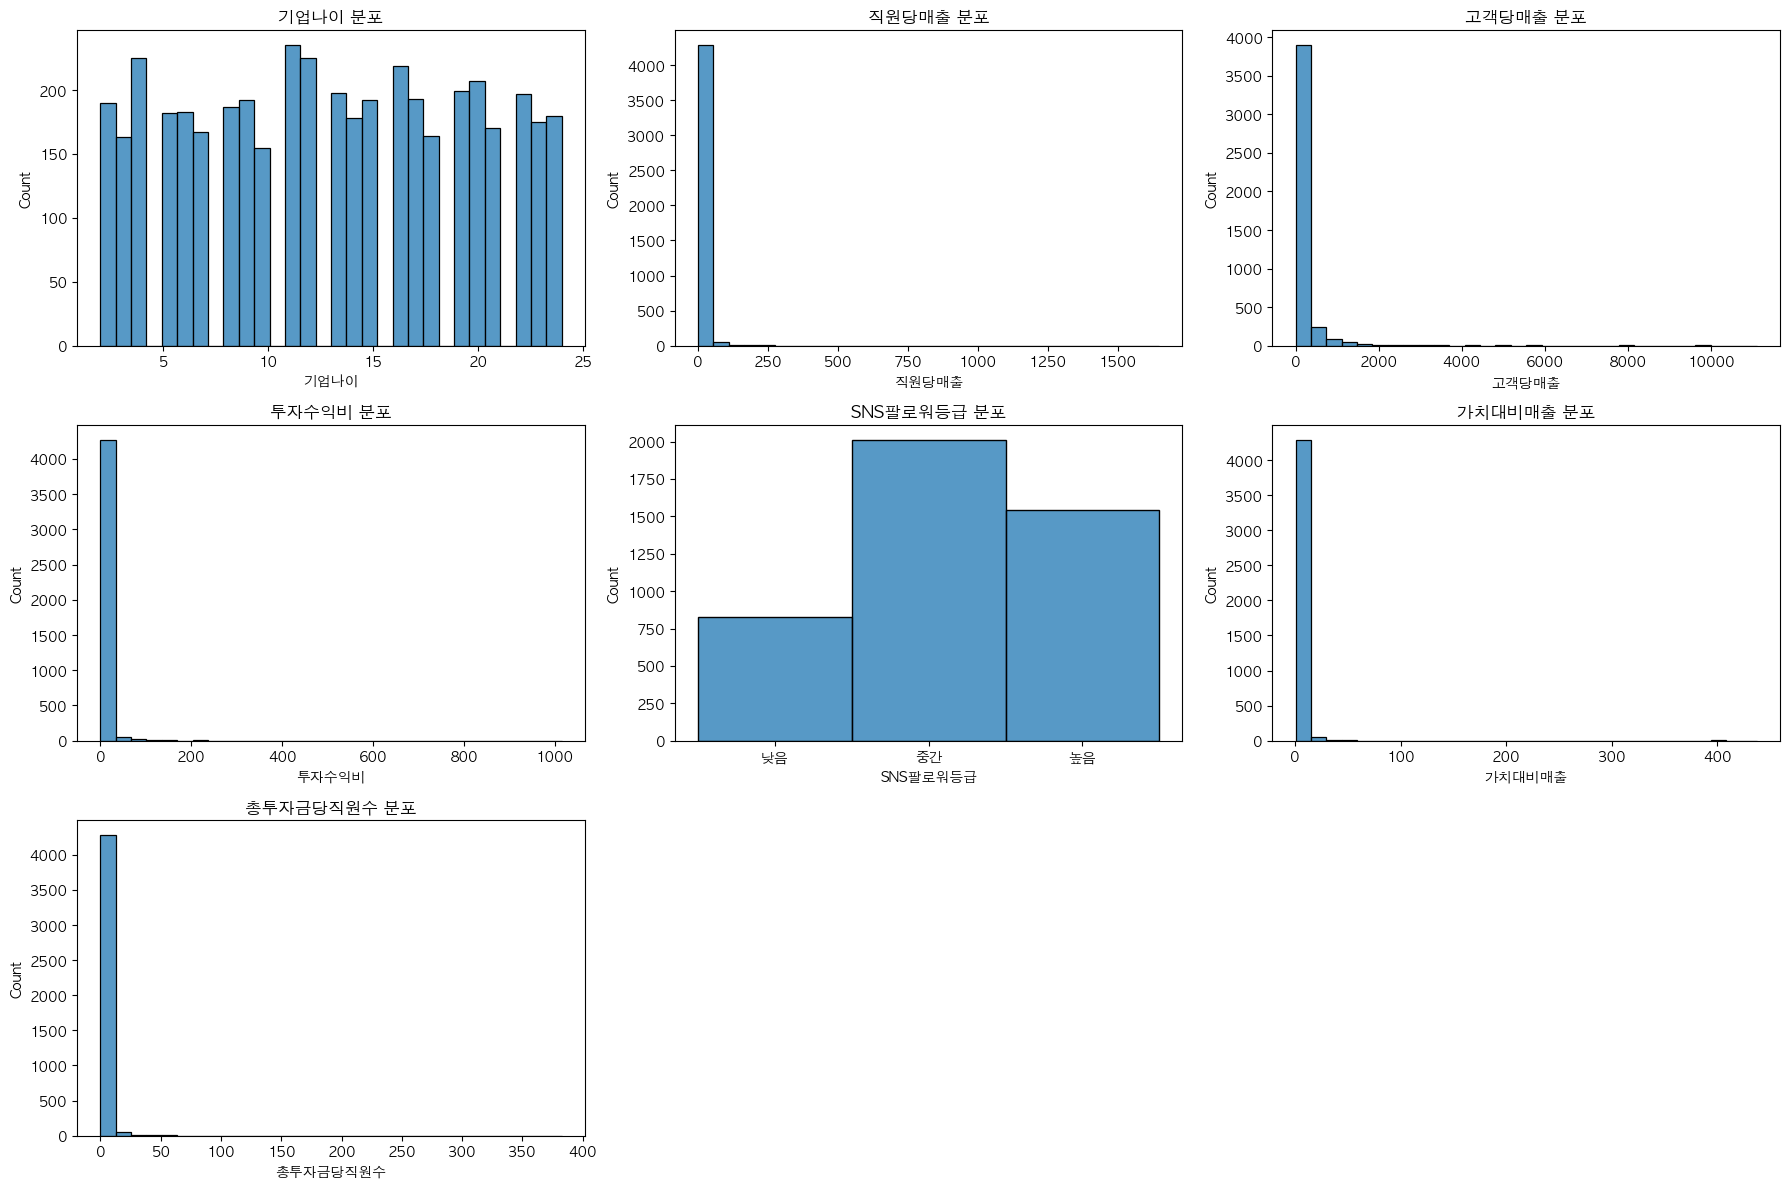

In [122]:

plt.figure(figsize=(18, 12))
for i, col in enumerate(derived_cols):
    plt.subplot(3, 3, i+1)
    sns.histplot(train[col].dropna(), kde=False, bins=30)
    plt.title(f'{col} 분포')
plt.tight_layout()
plt.show()

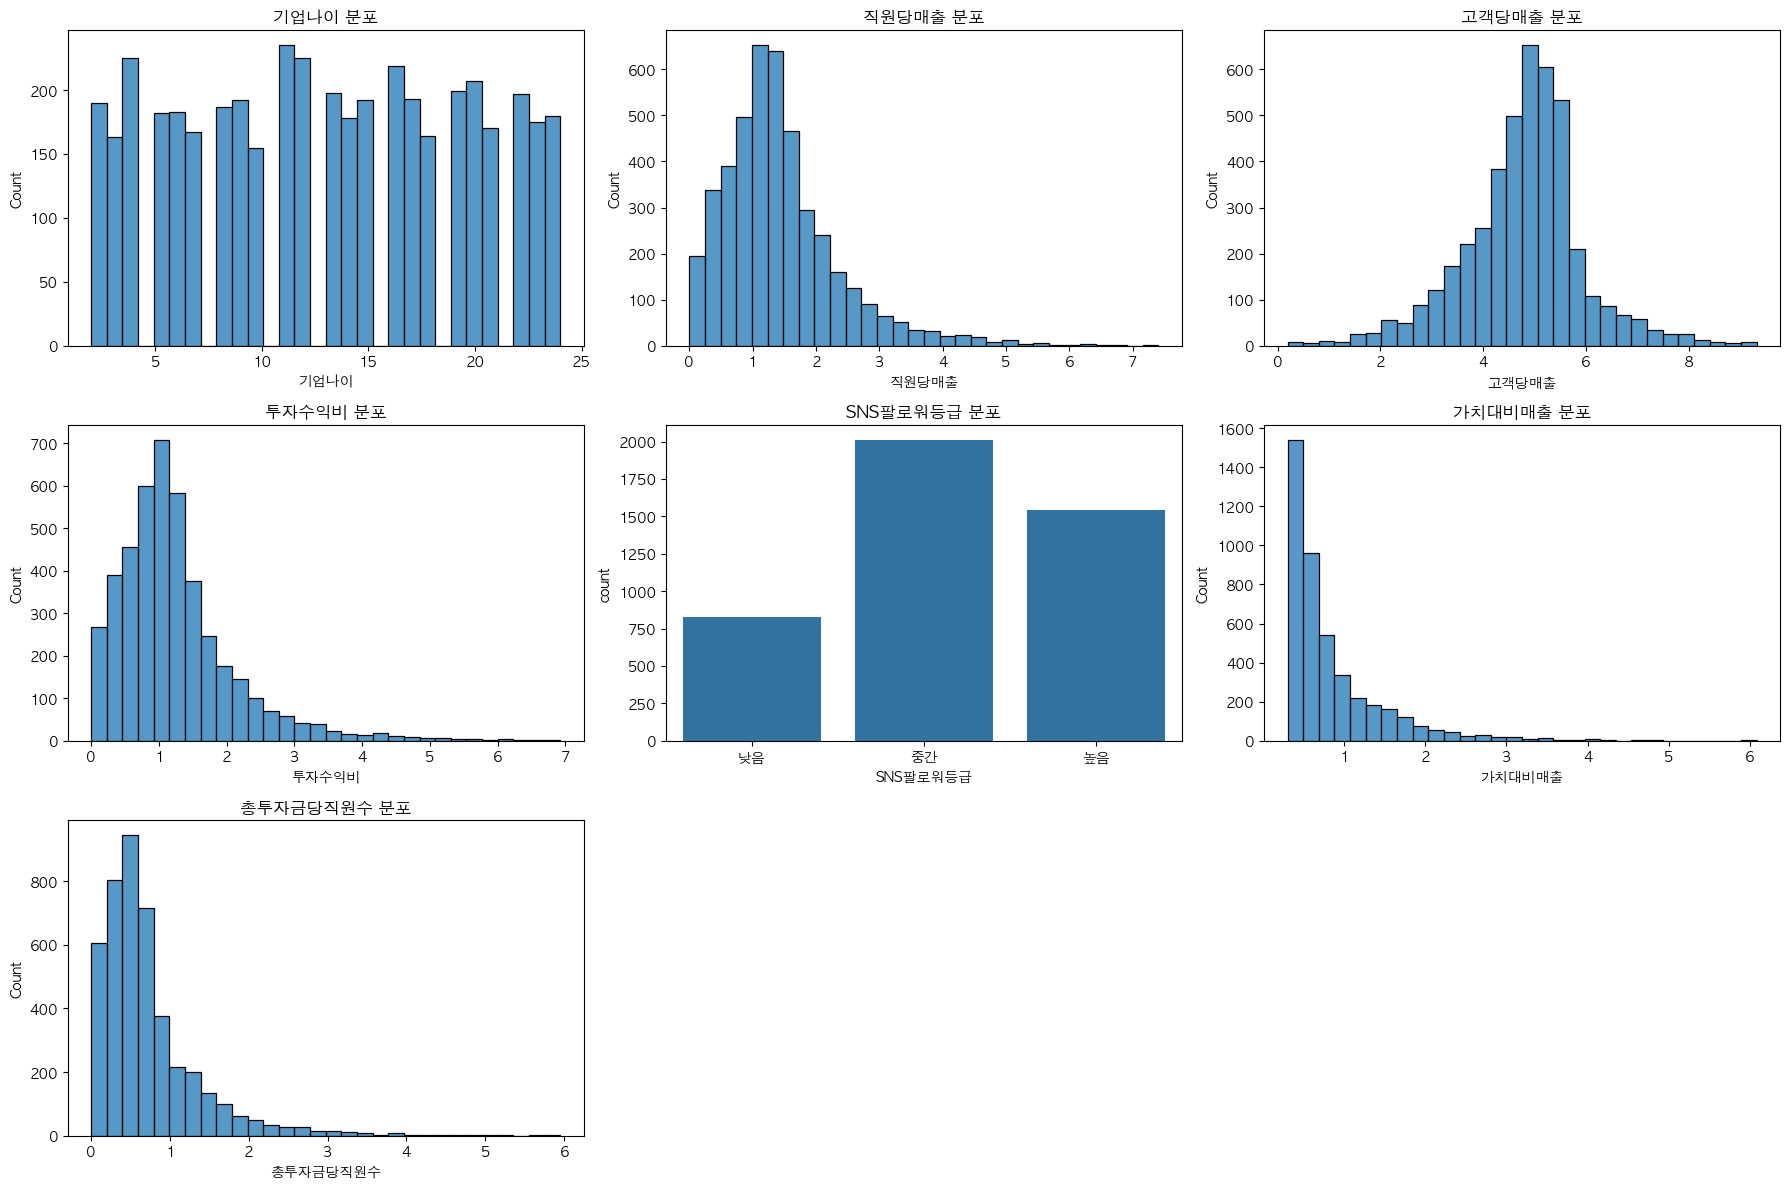

In [123]:

# 2. 로그 변환 대상 변수
log_cols = ['직원당매출', '고객당매출', '투자수익비', '가치대비매출', '총투자금당직원수']

# 3. 로그 변환 함수
def log_transform_columns(df, columns):
    df_copy = df.copy()
    for col in columns:
        # 0 이하 값 있는 경우 생략
        if (df_copy[col] > 0).all():
            df_copy[col] = np.log1p(df_copy[col])
        else:
            print(f"{col}: 0 이하 값 존재 → 로그 변환 생략")
    return df_copy

# 4. 로그 변환 적용
train_log = log_transform_columns(train, log_cols)

# 5. 파생변수 분포 시각화 (로그 변환 후 기준)
plt.figure(figsize=(18, 12))
for i, col in enumerate(derived_cols):
    plt.subplot(3, 3, i + 1)
    # SNS팔로워등급은 범주형이므로 막대그래프로 시각화
    if col == 'SNS팔로워등급':
        sns.countplot(x=train[col])
    else:
        sns.histplot(train_log[col].dropna(), kde=False, bins=30)
    plt.title(f'{col} 분포')
plt.tight_layout()
plt.show()

# 피쳐 중요도 확인

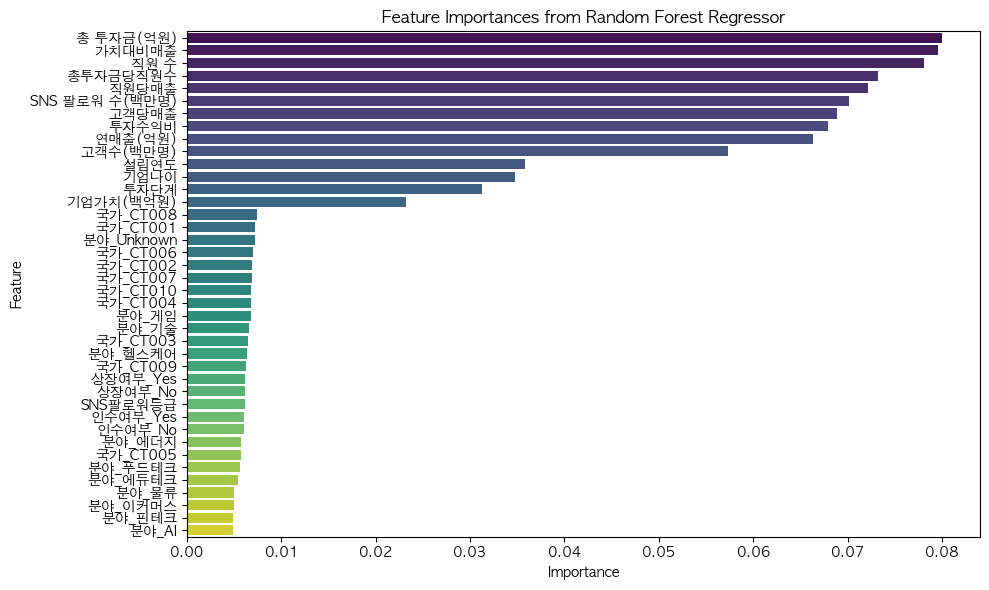

In [124]:

# 1. 데이터 불러오기
train = pd.read_csv('../../data/processed/processed_train.csv')
X = train.drop(columns=['성공확률', 'ID'])
y = train['성공확률']

# 2. 모델 정의 및 학습
model = RandomForestRegressor(random_state=42)
model.fit(X, y)

# 3. 피처 중요도 추출
feature_importances = model.feature_importances_
feature_names = X.columns

# 4. 시각화를 위한 데이터프레임 생성
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 5. 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importances from Random Forest Regressor')
plt.tight_layout()
plt.show()

In [125]:
target_cols = ['ID','총 투자금(억원)','가치대비매출','직원 수','총투자금당직원수',
               '직원당매출','SNS 팔로워 수(백만명)',
               '고객당매출','투자수익비','연매출(억원)','고객수(백만명)',
               '설립연도','기업나이','투자단계','기업가치(백억원)','성공확률']

target_cols_for_test = ['ID','총 투자금(억원)','가치대비매출','직원 수','총투자금당직원수',
               '직원당매출','SNS 팔로워 수(백만명)',
               '고객당매출','투자수익비','연매출(억원)','고객수(백만명)',
               '설립연도','기업나이','투자단계','기업가치(백억원)']



In [126]:
feature_importance_train = train[target_cols]
feature_importance_test = test[target_cols_for_test]

In [127]:
feature_importance_train.to_csv("../../data/processed/feature_importance_train.csv", index=False)
feature_importance_test.to_csv("../../data/processed/feature_importance_test.csv", index=False)


In [128]:
feature_importance_train

,ID,총 투자금(억원),가치대비매출,직원 수,총투자금당직원수,직원당매출,SNS 팔로워 수(백만명),고객당매출,투자수익비,연매출(억원),고객수(백만명),설립연도,기업나이,투자단계,기업가치(백억원),성공확률
0,TRAIN_3959,0.073081,0.001694,0.407170,0.010105,0.001406,0.908,0.035461,0.008842,0.318636,0.112245,0.909091,0.090909,0.75,0.476429,0.1
1,TRAIN_0733,0.233858,0.006809,0.609053,0.004792,0.000414,0.400,0.002390,0.001237,0.140176,0.785714,0.681818,0.318182,0.75,1.000000,0.1
2,TRAIN_3824,0.586491,0.000438,0.493956,0.001554,0.003112,0.596,0.023184,0.003014,0.855976,0.491983,0.454545,0.545455,0.00,0.476429,0.1
3,TRAIN_4168,0.168157,0.001011,0.363509,0.003970,0.002390,0.854,0.013109,0.005907,0.483930,0.491983,0.954545,0.045455,0.25,0.476429,0.1
4,TRAIN_3771,0.684972,0.001688,0.333267,0.000897,0.000830,0.352,0.004168,0.000464,0.153815,0.491983,0.772727,0.227273,1.00,0.000000,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3795,TRAIN_0836,0.594437,0.000445,0.919487,0.002855,0.000799,0.600,0.018187,0.001421,0.408980,0.295918,0.045455,0.954545,1.00,0.000000,0.9
3796,TRAIN_2467,0.637151,0.002070,0.047466,0.000136,0.009980,0.174,0.004301,0.000870,0.268197,0.836735,1.000000,0.000000,0.25,0.476429,0.9
3797,TRAIN_3181,0.669930,0.001681,0.169037,0.000464,0.005334,0.400,0.010016,0.001553,0.503646,0.673469,0.727273,0.272727,1.00,1.000000,0.9
3798,TRAIN_3923,0.313609,0.004469,0.676948,0.003978,0.000556,0.638,0.005670,0.001377,0.209251,0.491983,0.318182,0.681818,0.75,1.000000,0.9


# 학습

## XGBoost

In [129]:

train = pd.read_csv("../../data/processed/feature_importance_train.csv")
test = pd.read_csv("../../data/processed/feature_importance_test.csv")

# X, y 분리 (타겟 컬럼은 '성공확률'로 가정)
X = train.drop(columns=['ID', '성공확률'])
y = train['성공확률']  # ✅ 여기 수정됨

# XGBoost 하이퍼파라미터 세팅
params = {
    'booster': 'gbtree',
    'n_estimators': 100,
    'learning_rate': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 1.0,
    'colsample_bytree': 1.0,
    'gamma': 0,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'random_state': 42,
    'objective': 'reg:squarederror',  # 회귀용 objective
}

# 10-fold 교차검증 준비
kf = KFold(n_splits=10, shuffle=True, random_state=42)
mae_scores = []

for train_idx, val_idx in kf.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)

    preds = model.predict(X_val)
    mae = mean_absolute_error(y_val, preds)
    mae_scores.append(mae)

print(f"10-Fold CV MAE 평균: {np.mean(mae_scores):.4f}")
print(f"10-Fold CV MAE 표준편차: {np.std(mae_scores):.4f}")

#생성
submission = pd.DataFrame({
    'ID': test['ID'],
    '성공확률': test_preds.clip(0, 1)
})

submission.to_csv('../../data/output/final_submission/XGB.csv', index=False)

10-Fold CV MAE 평균: 0.2181
10-Fold CV MAE 표준편차: 0.0070


## Random Forest

In [130]:


train = pd.read_csv("../../data/processed/feature_importance_train.csv")
test = pd.read_csv("../../data/processed/feature_importance_test.csv")

# X, y 분리 (타겟 컬럼은 '성공확률'로 가정)
X = train.drop(columns=['ID', '성공확률'])
y = train['성공확률']  # ✅ 여기 수정됨


# RandomForest 하이퍼파라미터 세팅
params = {
    'n_estimators': 100,
    'criterion': 'absolute_error',  # 수정된 값
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 'sqrt',  # 필요시 'sqrt'로 바꾸셔도 됨
    'bootstrap': True,
    'random_state': 42,
    'n_jobs': -1
}
# 10-fold 교차검증 준비
kf = KFold(n_splits=10, shuffle=True, random_state=42)
mae_scores = []

for train_idx, val_idx in kf.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = RandomForestRegressor(**params)
    model.fit(X_train, y_train)

    preds = model.predict(X_val)
    mae = mean_absolute_error(y_val, preds)
    mae_scores.append(mae)

print(f"10-Fold CV MAE 평균: {np.mean(mae_scores):.4f}")
print(f"10-Fold CV MAE 표준편차: {np.std(mae_scores):.4f}")

#생성
submission = pd.DataFrame({
    'ID': test['ID'],
    '성공확률': test_preds.clip(0, 1)
})

submission.to_csv('../../data/output/final_submission/RF.csv', index=False)

10-Fold CV MAE 평균: 0.2069
10-Fold CV MAE 표준편차: 0.0085


## LGBM

In [131]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb

# 데이터 불러오기
train = pd.read_csv("../../data/processed/feature_importance_train.csv")
test = pd.read_csv("../../data/processed/feature_importance_test.csv")

# X, y 분리 (타겟 컬럼은 '성공확률'로 가정)
X = train.drop(columns=['ID', '성공확률'])
y = train['성공확률']  # ✅ 여기 수정됨

# LightGBM 하이퍼파라미터
params = {
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'max_depth': -1,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'subsample_for_bin': 200000,
    'min_split_gain': 0.0,
    'min_child_weight': 1e-3,
    'min_child_samples': 20,
    'subsample': 1.0,
    'subsample_freq': 0,
    'colsample_bytree': 1.0,
    'reg_alpha': 0.0,
    'reg_lambda': 0.0,
    'random_state': 42,
    'n_jobs': -1,
    'objective': 'regression',
    'metric': 'mae'
}

# 교차검증 설정
kf = KFold(n_splits=10, shuffle=True, random_state=42)
mae_scores = []

# 교차검증 수행
for train_idx, val_idx in kf.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)

    preds = model.predict(X_val)
    mae = mean_absolute_error(y_val, preds)
    mae_scores.append(mae)

# 결과 출력
print(f"10-Fold CV MAE 평균: {np.mean(mae_scores):.4f}")
print(f"10-Fold CV MAE 표준편차: {np.std(mae_scores):.4f}")

#생성
submission = pd.DataFrame({
    'ID': test['ID'],
    '성공확률': test_preds.clip(0, 1)
})

submission.to_csv('../../data/output/final_submission/LGBM.csv', index=False)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2434
[LightGBM] [Info] Number of data points in the train set: 3420, number of used features: 14
[LightGBM] [Info] Start training from score 0.540643
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2432
[LightGBM] [Info] Number of data points in the train set: 3420, number of used features: 14
[LightGBM] [Info] Start training from score 0.537544
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of test

## MLP

In [132]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import KFold
# from sklearn.metrics import mean_absolute_error
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Input, Dropout
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping

# train = pd.read_csv("../../data/processed/feature_importance_train.csv")
# test = pd.read_csv("../../data/processed/feature_importance_test.csv")


# # 데이터 준비
# X = train.drop(columns=['ID', '성공확률'])
# y = train['성공확률']
# X_test = test.drop(columns=['ID'])

# # 하이퍼파라미터
# learning_rate = 0.0001112408115243152
# batch_size = 16
# epochs = 471
# dropout1 = 0.06114446479113117
# dropout2 = 0.00037525412817682874
# dropout3 = 0.6447411638190662
# dropout4 = 0.40273771947175707
# units1 = 462
# units2 = 466
# units3 = 230
# units4 = 248
# n_layers = 3

# # 예측 결과 저장용
# test_preds = np.zeros(len(X_test))
# val_mae_list = []

# # 10-Fold 교차 검증 설정
# kf = KFold(n_splits=10, shuffle=True, random_state=42)

# for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
#     print(f'\n🔁 Fold {fold+1}')
    
#     # 데이터 분리
#     X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#     y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
#     # 모델 구성
#     model = Sequential()
#     model.add(Input(shape=(X.shape[1],)))
#     model.add(Dense(units1, activation='relu'))
#     model.add(Dropout(dropout1))
    
#     if n_layers >= 2:
#         model.add(Dense(units2, activation='relu'))
#         model.add(Dropout(dropout2))
    
#     if n_layers >= 3:
#         model.add(Dense(units3, activation='relu'))
#         model.add(Dropout(dropout3))
    
#     if n_layers >= 4:
#         model.add(Dense(units4, activation='relu'))
#         model.add(Dropout(dropout4))
    
#     model.add(Dense(1))  # 출력층

#     model.compile(
#         optimizer=Adam(learning_rate=learning_rate),
#         loss='mean_absolute_error',
#         metrics=['mean_absolute_error']
#     )
    
#     early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True, verbose=0)
    
#     model.fit(
#         X_train, y_train,
#         epochs=epochs,
#         batch_size=batch_size,
#         verbose=0,
#         callbacks=[early_stop]
#     )
    
#     # 검증 성능 저장
#     val_pred = model.predict(X_val).flatten()
#     val_mae = mean_absolute_error(y_val, val_pred)
#     val_mae_list.append(val_mae)
#     print(f'📉 Fold {fold+1} MAE: {val_mae:.4f}')
    
#     # 테스트 예측 (각 fold 결과 평균)
#     test_preds += model.predict(X_test).flatten() / kf.n_splits

# # 전체 검증 결과 출력
# print(f'\n✅ 평균 검증 MAE: {np.mean(val_mae_list):.4f} ± {np.std(val_mae_list):.4f}')

# # 제출 파일 생성
# submission = pd.DataFrame({
#     'ID': test['ID'],
#     '성공확률': test_preds.clip(0, 1)
# })

# submission.to_csv('../../data/output/final_submission/MLP.csv', index=False)

# 예측 결과 비교

In [133]:
test = pd.read_csv("../../data/raw/test.csv")
lgbm = pd.read_csv("../../data/output/final_submission/LGBM.csv")
mlp = pd.read_csv("../../data/output/final_submission/MLP.csv")
rf = pd.read_csv("../../data/output/final_submission/RF.csv")
xgb = pd.read_csv("../../data/output/final_submission/XGB.csv")

In [134]:
lgbm = lgbm['성공확률']
mlp = mlp['성공확률']
rf = rf['성공확률']
xgb = xgb['성공확률']
test_id = test['ID']

In [135]:
result_df = pd.DataFrame({
    "ID": test_id,
    'LGBM':lgbm,
    'RandomForest': rf,
    'MLP':mlp,
    'XGBoost':xgb
})

In [136]:
result_df

,ID,LGBM,RandomForest,MLP,XGBoost
0,TEST_0000,1.0,1.0,0.491683,1.0
1,TEST_0001,1.0,1.0,0.592654,1.0
2,TEST_0002,0.0,0.0,0.537438,0.0
3,TEST_0003,0.0,0.0,0.589705,0.0
4,TEST_0004,1.0,1.0,0.576473,1.0
...,...,...,...,...,...
1750,TEST_1750,1.0,1.0,0.574418,1.0
1751,TEST_1751,0.0,0.0,0.589463,0.0
1752,TEST_1752,1.0,1.0,0.598798,1.0
1753,TEST_1753,1.0,1.0,0.508765,1.0


In [137]:
result_df.describe()

,LGBM,RandomForest,MLP,XGBoost
count,1755.000000,1755.000000,1755.000000,1755.000000
mean,0.657883,0.657883,0.547759,0.657883
std,0.472729,0.472729,0.080562,0.472729
min,0.000000,0.000000,0.177041,0.000000
25%,0.000000,0.000000,0.501354,0.000000
50%,1.000000,1.000000,0.547849,1.000000
75%,1.000000,1.000000,0.594763,1.000000
max,1.000000,1.000000,1.000000,1.000000


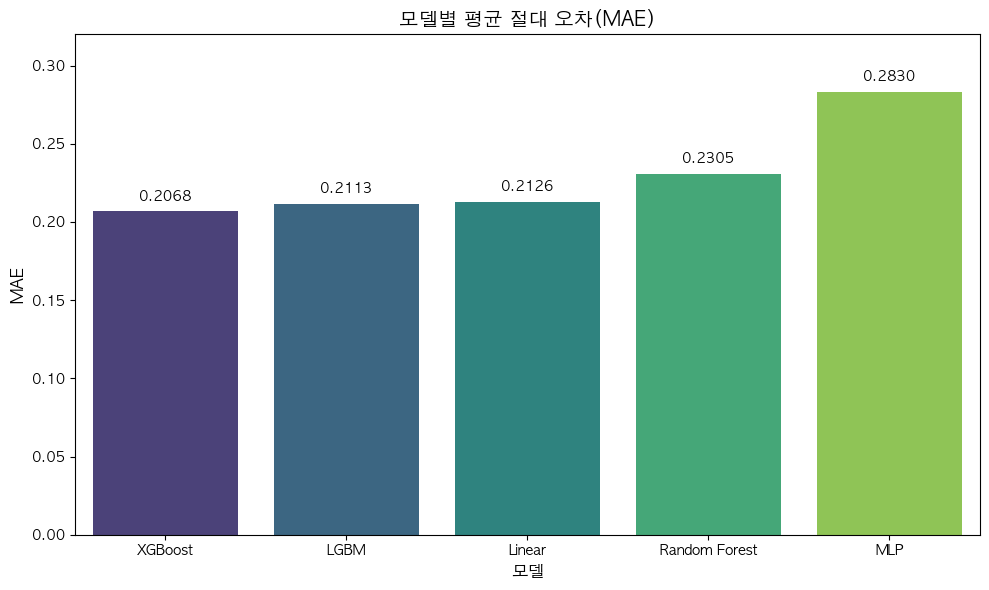

In [138]:
# 모델별 MAE 값
mae_scores = {
    'XGBoost': 0.2068,
    'LGBM': 0.2113,
    'Linear': 0.2126,
    'Random Forest': 0.2305,
    'MLP': 0.2830
}

# 시각화용 데이터프레임 변환
import pandas as pd
mae_df = pd.DataFrame(list(mae_scores.items()), columns=['모델', 'MAE'])

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(data=mae_df, x='모델', y='MAE', palette='viridis')

# 값 표시
for index, value in enumerate(mae_df['MAE']):
    plt.text(index, value + 0.005, f'{value:.4f}', ha='center', va='bottom')

plt.title('모델별 평균 절대 오차(MAE)', fontsize=14)
plt.xlabel('모델', fontsize=12)
plt.ylabel('MAE', fontsize=12)
plt.ylim(0, 0.32)
plt.tight_layout()
plt.show()